## Momentum Model using Deep Learning

In [65]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from functools import reduce
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation,Dropout, LSTM,Flatten
from tensorflow.keras.models import Sequential

In [2]:
# Read the CSV file and keep on the largest 30 companies
df = pd.read_csv('nasdaq_screener_1613878479181.csv')
stocks = df[~(df['IPO Year']>2020)].dropna().sort_values(by='Market Cap')['Symbol'].iloc[-30:].tolist()
stocks.sort()

In [60]:
# Each element of the list is a dataframe with the Adjusted closing prices of each ticker.
securities_by_date = []
for i in stocks:
    df = yf.download(i,start= '2008-01-01',end=None , interval = '1wk')[['Adj Close']].dropna().pct_change(periods = 5).dropna().rename(columns={'Adj Close':i})
    securities_by_date.append(df)
    


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
class Momentum_Model:
    
    def __init__(self,df, window, future):
        
        self.df, self.window, self.future, = df, window, future
        
        # Split the data to train and test
        train_df = self.df[0:int(len(self.df)*0.7)]
        test_df = self.df[int(len(self.df)*0.7):]
        # Get means and std for the columns of the dataframe
        train_mean = train_df.mean()
        train_std = train_df.std()
        # Normalize the data by subtracting the mean and std of the train set
        train_df = (train_df - train_mean) / train_std
        test_df = (test_df - train_mean) / train_std
        # Convert the normalized data to numpy array.
        train_df, test_df = train_df.to_numpy(), test_df.to_numpy()
        
        self.train_df, self.test_df, self.train_mean, self.train_std = train_df, test_df, train_mean, train_std 
    
    def layout(self):
        
        # Train Layout
        X_train = []
        y_train = []
        for i in range(self.window,len(self.train_df) - self.future):
            X_train.append(self.train_df[i - self.window:i])  
            y_train.append(self.train_df[i + self.future,0:1])  
        
        X_train, y_train = np.array(X_train),np.array(y_train)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],self.train_df.shape[1])
        
        # Test Layout
        X_test = []
        y_test = []
        for i in range(self.window,len(self.test_df)-self.future):
            X_test.append(self.test_df[i - self.window:i])
            y_test.append(self.test_df[i + self.future,0:1])
            
        X_test, y_test = np.array(X_test),np.array(y_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], self.test_df.shape[1])
        
        return X_train, y_train, X_test, y_test
    
    def Rnn_model(self, X):
        
        self.X = X
        
        model = Sequential()
        model.add(LSTM(units=50,activation = 'tanh' , return_sequences=True, input_shape=(self.X.shape[1], self.X.shape[2])))
        model.add(Dropout(0.2))
        model.add(LSTM(units = 30,activation ='sigmoid', return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(units = 30,activation ='sigmoid', return_sequences = False))
        model.add(Dense(1))
        
        return model
    
    def predictions(self, model, epochs, X_train, y_train, X_test, y_test):
        
        self.model, self.epochs, self.X_train, self.y_train, self.X_test, self.y_test  = model, epochs, X_train, y_train, X_test, y_test
        opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
        self.model.compile(optimizer = opt, loss = 'mean_squared_error')
        self.model.fit(self.X_train, self.y_train, epochs = self.epochs, batch_size = 30, verbose = 0)
        
        predictions = self.model.predict(self.X_test)*self.train_std.tolist()[0] + self.train_mean.tolist()[0]
        
        y_test_inverse_transform = self.y_test*self.train_std.tolist()[0] + self.train_mean.tolist()[0]
        
        return [predictions.flatten(), y_test_inverse_transform.flatten()]

In [5]:
stock_predictions = []
for df in securities_by_date:  
    
    data = Momentum_Model(df,5,0)
    X_train, y_train, X_test, y_test = data.layout()
    volume_model = data.Rnn_model(X_train)
    predictions = data.predictions(volume_model, 100, X_train, y_train, X_test,y_test)
    stock_predictions.append(predictions)

In [61]:
data = Volume_Model(securities_by_date[0],5,0)
X_train, y_train, X_test, y_test = data.layout()
volume_model = data.Rnn_model(X_train)
predictions = data.predictions(volume_model, 100, X_train, y_train, X_test, y_test)

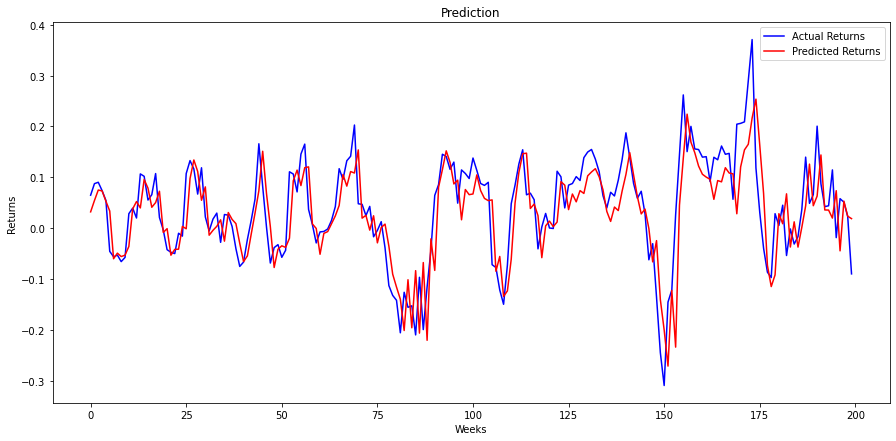

In [70]:
plt.figure(figsize=(15,7))
plt.plot(predictions[1], color='blue', label='Actual Returns')
plt.plot(predictions[0] , color='red', label='Predicted Returns')
plt.title('Prediction')
plt.xlabel('Weeks')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [6]:
prediction_data = [stock_predictions[i][0].tolist() for i in range(len(stock_predictions))]

In [7]:
list_of_predictions = []
dates = pd.date_range(start='1/1/2008', end=datetime.today().strftime('%Y-%m-%d')).tolist()[::7]
for i in range(len(prediction_data)):
    
    df = pd.DataFrame(prediction_data[i]).rename(columns={0:stocks[i]})
    df['Date'] = dates[-len(df.index):]
    list_of_predictions.append(df.set_index('Date'))

In [8]:
df_predictions = reduce(lambda left,right: pd.merge(left,right,on='Date', how = 'outer'), list_of_predictions).fillna(-1000)

In [88]:
column_names = ['10th','9th', '8th', '7th', '6th', '5th', '4th', "3rd", "2nd", "1st"]
    
performance = pd.DataFrame(columns = column_names)
for i in range(len(df_predictions)):
    performance.loc[len(performance)] = df_predictions.iloc[i].T.sort_values().iloc[-10:].reset_index()['index'].tolist()
    
performance['Date'] = dates[-len(performance.index):]

performance

,10th,9th,8th,7th,6th,5th,4th,3rd,2nd,1st,Date
0,AAPL,ADBE,MA,CRM,HDB,SBUX,MSFT,NFLX,GOOG,AMZN,2017-04-25
1,CSCO,CRM,TSM,AMZN,ACN,HDB,MSFT,AAPL,NFLX,GOOG,2017-05-02
2,ASML,CSCO,CRM,HDB,TSM,ACN,AAPL,NFLX,GOOG,NVDA,2017-05-09
3,AMZN,ADBE,HDB,NFLX,AAPL,ACN,QCOM,TSM,GOOG,NVDA,2017-05-16
4,HDB,CRM,AAPL,ADBE,AMZN,GOOG,TSM,QCOM,NFLX,NVDA,2017-05-23
...,...,...,...,...,...,...,...,...,...,...,...
195,SHOP,ABBV,QCOM,TSM,JD,AMGN,SE,PDD,ASML,TSLA,2021-01-19
196,MSFT,GOOG,AMGN,QCOM,TSM,HDB,ASML,JD,TSLA,SE,2021-01-26
197,TSM,JD,HDB,ASML,MSFT,NVDA,TSLA,GOOG,BABA,SE,2021-02-02
198,CRM,ASML,SHOP,NFLX,NVDA,TSLA,MSFT,GOOG,BABA,SE,2021-02-09


In [51]:
portfolio_performance = []
portfolio_weights = np.array([1/10,1/10,1/10,1/10,1/10,1/10,1/10,1/10,1/10,1/10])

for i in range(len(performance.index) - 2):
    weekly_securities = yf.download(performance.iloc[i][0:10].tolist(),start= performance.iloc[i][10] ,end= performance.iloc[i+1][10], interval = '1wk')['Open']
    
    weekly_securities_2 = weekly_securities.reset_index().dropna().drop_duplicates(subset=['Date']).set_index('Date').pct_change().dropna().values.flatten()
    portfolio_performance.append(weekly_securities_2)

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*****

In [52]:
final_performance = []
for j in portfolio_performance:
        
    try:
        final = j@portfolio_weights
        
    except TypeError:
        final = math.nan
        
    except ValueError:
        final = math.nan
        
   
        
    final_performance.append(final)
    

In [53]:
spy = yf.download('SPY',start= performance.iloc[0][10] ,end= performance.iloc[-2][10], interval = '1wk')['Adj Close'].dropna().pct_change(periods =1).dropna().reset_index()

[*********************100%***********************]  1 of 1 completed


In [54]:
df_final = pd.DataFrame({'Portfolio Performance':final_performance, 'SPY':spy['Adj Close']}).fillna(method='ffill').cumsum()

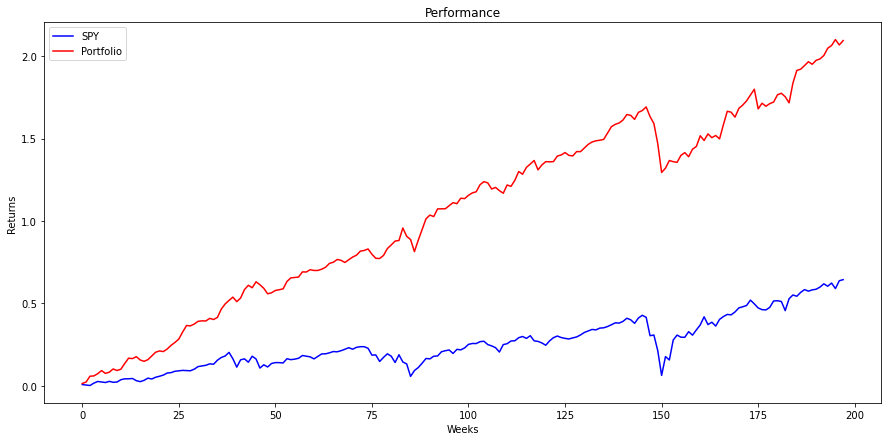

In [71]:
plt.figure(figsize=(15,7))
plt.plot(df_final['SPY'], color='blue', label='SPY')
plt.plot(df_final['Portfolio Performance'] , color='red', label='Portfolio')
plt.title('Performance')
plt.xlabel('Weeks')
plt.ylabel('Returns')
plt.legend()
plt.show()